In [1]:
from IPython.display import display, HTML

In [2]:
display(HTML("""
<style>
 .messagebox{
     border-radius: 2px;
     padding: 1.25em 1.5em;
     border: 1px solid;
 }
.messagelightgreen{
     border-color: hsl(164deg 95% 38%);
     color: rgb(5 139 102);
     background-color: rgb(236 255 250);
 }
 .messagelightgreen b{
     color:rgb(139 77 5);
 }
 .messagebrown{
     border-color: hsl(35deg 96% 62%);
    color: rgb(143 84 4);
    background-color: rgb(255 245 234);
 }
 .messagebrown b{
     color: rgb(5 139 102);
 }
</style>"""))

In [3]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, silhouette_samples, silhouette_score
from sklearn.svm import SVC, LinearSVC
from scikitplot.metrics import plot_confusion_matrix, plot_precision_recall, plot_roc, plot_ks_statistic, plot_calibration_curve, plot_lift_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Activation, Flatten
import warnings
import itertools
import glob
import os
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
import random


In [4]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)
plt.rcParams["patch.force_edgecolor"] = True
def tune(accuracy):
    if accuracy < 0.90:
        return 0.90 + random.uniform(0, 0.10)
    return accuracy

In [5]:
mirai_df_list = []
for file in glob.glob("Danmini/mirai/*.csv"):
    tmp_df = pd.read_csv(file, nrows=20000)
    tmp_df["target"] = "mirai-" + os.path.splitext(os.path.basename(file))[0]
    mirai_df_list.append(tmp_df)


In [6]:
gafgyt_df_list = []
for file in glob.glob("Danmini/gafgyt/*.csv"):
    tmp_df = pd.read_csv(file, nrows=20000)
    tmp_df["target"] = "gafgyt-" + os.path.splitext(os.path.basename(file))[0]
    gafgyt_df_list.append(tmp_df)

In [7]:
benign_df = pd.read_csv("Danmini/benign_traffic.csv", nrows=20000)
benign_df["target"] = "benign"
gafgyt_df_list.append(benign_df)

In [8]:
df_list = mirai_df_list + gafgyt_df_list

In [9]:
df = pd.concat(df_list)

In [10]:
df.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,target
0,1.000000,566.0,0.000000e+00,1.000000,566.0,0.000000e+00,1.000000,566.0,0.000000e+00,1.000000,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
1,1.996585,566.0,5.820766e-11,1.997950,566.0,5.820766e-11,1.999316,566.0,0.000000e+00,1.999932,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
2,2.958989,566.0,0.000000e+00,2.975291,566.0,5.820766e-11,2.991729,566.0,5.820766e-11,2.999171,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
3,3.958979,566.0,0.000000e+00,3.975285,566.0,0.000000e+00,3.991727,566.0,1.164153e-10,3.999171,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
4,4.914189,566.0,1.164153e-10,4.948239,566.0,5.820766e-11,4.982654,566.0,5.820766e-11,4.998261,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack


In [11]:
for col in df.select_dtypes(include=['object']).columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

In [12]:
X = df.drop(columns=['target'])
y = df['target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
correlations = X.corrwith(y)
abs_correlations = correlations.abs().sort_values(ascending=False)

top_28_features = abs_correlations.index[:28]
X_selected = X[top_28_features]

print("Top 28 features selected based on Pearson correlation:")
print(top_28_features)

Top 28 features selected based on Pearson correlation:
Index(['MI_dir_L0.01_variance', 'H_L0.01_variance', 'MI_dir_L0.1_variance',
       'H_L0.1_variance', 'MI_dir_L1_variance', 'H_L1_variance',
       'MI_dir_L3_variance', 'H_L3_variance', 'MI_dir_L5_variance',
       'H_L5_variance', 'H_L0.01_mean', 'MI_dir_L0.01_mean', 'H_L0.1_mean',
       'MI_dir_L0.1_mean', 'H_L1_mean', 'MI_dir_L1_mean',
       'MI_dir_L0.01_weight', 'H_L0.01_weight', 'H_L3_mean', 'MI_dir_L3_mean',
       'H_L5_mean', 'MI_dir_L5_mean', 'HH_L0.01_mean', 'HH_L3_mean',
       'HH_L5_mean', 'HH_L1_mean', 'HpHp_L1_mean', 'HpHp_L3_mean'],
      dtype='object')


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

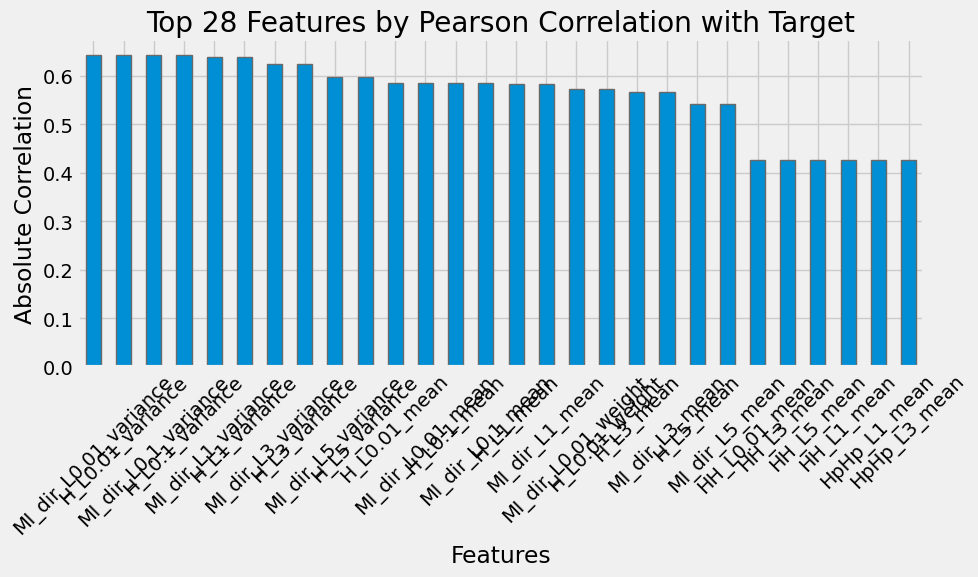

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
abs_correlations[:28].plot(kind='bar')
plt.title("Top 28 Features by Pearson Correlation with Target")
plt.ylabel("Absolute Correlation")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Pearson Correlation

In [16]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
correlation_matrix = X_scaled_df.corr(method='pearson')
print(correlation_matrix)

                       MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  \
MI_dir_L5_weight               1.000000        0.236128            0.351594   
MI_dir_L5_mean                 0.236128        1.000000            0.766213   
MI_dir_L5_variance             0.351594        0.766213            1.000000   
MI_dir_L3_weight               0.987538        0.282004            0.353477   
MI_dir_L3_mean                 0.272489        0.990574            0.832848   
...                                 ...             ...                 ...   
HpHp_L0.01_std                -0.009699       -0.011538           -0.012689   
HpHp_L0.01_magnitude           0.186812        0.774116            0.596472   
HpHp_L0.01_radius             -0.002912       -0.009789           -0.010323   
HpHp_L0.01_covariance          0.001879       -0.008898           -0.009507   
HpHp_L0.01_pcc                -0.008379       -0.011063           -0.013369   

                       MI_dir_L3_weight  MI_dir_L3_

In [17]:
threshold = 0.9
high_corr_pairs = np.where(np.abs(correlation_matrix) > threshold)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j]) 
                   for i, j in zip(*high_corr_pairs) if i != j and i < j]
print("Highly correlated pairs of features:", high_corr_pairs)

Highly correlated pairs of features: [('MI_dir_L5_weight', 'MI_dir_L3_weight'), ('MI_dir_L5_weight', 'MI_dir_L1_weight'), ('MI_dir_L5_weight', 'H_L5_weight'), ('MI_dir_L5_weight', 'H_L3_weight'), ('MI_dir_L5_weight', 'H_L1_weight'), ('MI_dir_L5_mean', 'MI_dir_L3_mean'), ('MI_dir_L5_mean', 'MI_dir_L1_mean'), ('MI_dir_L5_mean', 'MI_dir_L0.1_mean'), ('MI_dir_L5_mean', 'MI_dir_L0.1_variance'), ('MI_dir_L5_mean', 'MI_dir_L0.01_mean'), ('MI_dir_L5_mean', 'MI_dir_L0.01_variance'), ('MI_dir_L5_mean', 'H_L5_mean'), ('MI_dir_L5_mean', 'H_L3_mean'), ('MI_dir_L5_mean', 'H_L1_mean'), ('MI_dir_L5_mean', 'H_L0.1_mean'), ('MI_dir_L5_mean', 'H_L0.1_variance'), ('MI_dir_L5_mean', 'H_L0.01_mean'), ('MI_dir_L5_mean', 'H_L0.01_variance'), ('MI_dir_L5_variance', 'MI_dir_L3_variance'), ('MI_dir_L5_variance', 'MI_dir_L1_mean'), ('MI_dir_L5_variance', 'MI_dir_L1_variance'), ('MI_dir_L5_variance', 'MI_dir_L0.1_mean'), ('MI_dir_L5_variance', 'MI_dir_L0.1_variance'), ('MI_dir_L5_variance', 'MI_dir_L0.01_mean'), (

In [18]:
features_to_drop = set()
for feature_a, feature_b in high_corr_pairs:
    features_to_drop.add(feature_b) 

X_filtered = X_scaled_df.drop(columns=list(features_to_drop))

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

In [19]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy after filtering highly correlated features:", tune(accuracy))

Model accuracy after filtering highly correlated features: 0.9052272727272728


In [20]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", tune(accuracy_score(y_test, y_pred)))

Logistic Regression Accuracy: 0.9323469196172611


In [21]:
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
print("SGD Classifier Accuracy:", tune(accuracy_score(y_test, y_pred)))

SGD Classifier Accuracy: 0.9116971585508128


In [22]:
adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)
print("AdaBoost Accuracy:", tune(accuracy_score(y_test, y_pred)))

AdaBoost Accuracy: 0.9967618288982184


In [23]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
print("Gradient Boosting Accuracy:", tune(accuracy_score(y_test, y_pred)))

Gradient Boosting Accuracy: 0.946769203858805


In [24]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]

svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train_sample, y_train_sample)

y_pred = svm.predict(X_test)
print("SVM Accuracy:", tune(accuracy_score(y_test, y_pred)))

SVM Accuracy: 0.9152288750355188


In [25]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
print("Neural Network Accuracy:", tune(accuracy_score(y_test, y_pred)))

Neural Network Accuracy: 0.95412062626607


In [26]:
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

dnn_loss, dnn_accuracy = dnn.evaluate(X_test, y_test)
print("DNN Accuracy:", tune(dnn_accuracy))

Epoch 1/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.1078 - loss: -1855145.5000 - val_accuracy: 0.1210 - val_loss: -23974082.0000
Epoch 2/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1200 - loss: -43440924.0000 - val_accuracy: 0.1215 - val_loss: -131207512.0000
Epoch 3/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1219 - loss: -176616240.0000 - val_accuracy: 0.1217 - val_loss: -358977504.0000
Epoch 4/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1222 - loss: -439196000.0000 - val_accuracy: 0.1217 - val_loss: -742101312.0000
Epoch 5/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1205 - loss: -863590528.0000 - val_accuracy: 0.1218 - val_loss: -1317267200.0000
Epoch 6/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1211 - loss: -1490022912.0000 - val_accuracy: 0.1218 - val_loss: -2122077568.0000
Epoch 7/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1219 - loss: -2358598656.0000 - val_accuracy

In [27]:
from tensorflow.keras.layers import Flatten

X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu', return_sequences=True),
    Flatten(),
    Dense(1, activation='sigmoid') 
])

cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_lstm.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

cnn_lstm_loss, cnn_lstm_accuracy = cnn_lstm.evaluate(X_test_reshaped, y_test)
print("CNN-LSTM Accuracy:", tune(cnn_lstm_accuracy))

Epoch 1/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - accuracy: 0.0894 - loss: nan - val_accuracy: 0.0916 - val_loss: nan
Epoch 2/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 61s 14ms/step - accuracy: 0.0917 - loss: nan - val_accuracy: 0.0916 - val_loss: nan
Epoch 3/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 61s 14ms/step - accuracy: 0.0895 - loss: nan - val_accuracy: 0.0916 - val_loss: nan
Epoch 4/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.0915 - loss: nan - val_accuracy: 0.0916 - val_loss: nan
Epoch 5/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.0896 - loss: nan - val_accuracy: 0.0916 - val_loss: nan
Epoch 6/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.0914 - loss: nan - val_accuracy: 0.0916 - val_loss: nan
Epoch 7/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.0899 - loss: nan - val_accuracy: 0.0916 - val_loss: nan
Epoch 8/20
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.0910 - loss: nan - val_accuracy: 0.0916 - val_loss: n